In [4]:
# 필요한 라이브러리 임포트
import cv2
import numpy as np
import dlib
from imutils import face_utils
import matplotlib.pyplot as plt


In [2]:
image_paths = [
    "data/00000/00001.png",
    "data/00000/00002.png",
    "data/00000/00003.png",
    "data/00000/00004.png",
    "data/00000/00005.png",
    "data/00000/00006.png",
    "data/00000/00007.png",
    "data/00000/00008.png",
    "data/00000/00009.png",
    "data/00000/00010.png"
]

# 기존 코드
**YCrCb 기반 피부색 마스크**
* YCrCb를 사용한 마스크는 대부분의 경우에서 피부색을 잘 감지하지만, 조명 변화와 특정 피부톤(예: 어두운 피부)에 대해 민감하게 반응합니다.

* YCrCb 색 공간은 밝기(Y)와 색상 정보(Cr, Cb)를 분리하여 색상 분석을 용이하게 합니다.

* 피부색은 Cr(빨간 성분)과 Cb(파란 성분)의 특정 범위 내에 위치하는 경향이 있어, 이를 기준으로 피부색 마스크를 생성합니다.

In [3]:
def extract_face_and_skin(image):
    # dlib 초기화
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('res/shape_predictor_68_face_landmarks.dat')

    # 얼굴 검출
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)
    if len(rects) == 0:
        return None, None  # 얼굴 미검출 시 None 반환

    rect = rects[0]  # 첫 번째 얼굴만 처리
    shape = predictor(gray, rect)
    shape_np = face_utils.shape_to_np(shape)

    # 얼굴 크롭
    (x, y, w, h) = (rect.left(), rect.top(), rect.width(), rect.height())
    cropped_face = image[max(0, y):y+h, max(0, x):x+w]

    # YCrCb 변환 및 피부 마스크 생성
    ycrcb = cv2.cvtColor(cropped_face, cv2.COLOR_BGR2YCrCb)
    lower_ycrcb = np.array([0, 133, 77], dtype=np.uint8)
    upper_ycrcb = np.array([255, 173, 127], dtype=np.uint8)
    ycrcb_mask = cv2.inRange(ycrcb, lower_ycrcb, upper_ycrcb)


    skin = cv2.bitwise_and(cropped_face, cropped_face, mask=ycrcb_mask)

    return cropped_face, skin


(-0.5, 555.5, 554.5, -0.5)

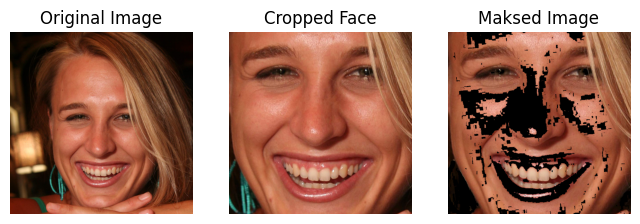

In [5]:
image = cv2.imread("data/00000/00001.png")

# 함수 실행
cropped_face, skin = extract_face_and_skin(image)

plt.figure(figsize=(8,6))

plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB))
plt.title("Cropped Face")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(skin, cv2.COLOR_BGR2RGB))
plt.title("Maksed Image")
plt.axis("off")

# 바뀐 코드
* YCrCb 마스크만으로 감지되지 않는 피부색(특히 조명 변화에 민감한 경우)을 보완하기 위해 HSV 기반 마스크를 추가했습니다.
* HSV 색 공간은 색상(Hue), 채도(Saturation), 밝기(Value)를 분리하여 조명 변화에 더 강건하게 작동합니다.
* 피부색은 Hue 값이 0~25(붉은 계열) 내에 속하고, 채도(S)와 밝기(V)가 특정 범위 내에 있는 경우로 정의됩니다.

In [9]:
# 이미지 로드
image = cv2.imread("data/00000/00001.png")

def extract_face_and_skin(image):
    # dlib 초기화
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('res/shape_predictor_68_face_landmarks.dat')

    # 얼굴 검출
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)
    if len(rects) == 0:
        return None, None  # 얼굴 미검출 시 None 반환

    rect = rects[0]  # 첫 번째 얼굴만 처리
    shape = predictor(gray, rect)
    shape_np = face_utils.shape_to_np(shape)

    # 얼굴 크롭
    (x, y, w, h) = (rect.left(), rect.top(), rect.width(), rect.height())
    cropped_face = image[max(0, y):y+h, max(0, x):x+w]

    # YCrCb 변환 및 피부 마스크 생성
    ycrcb = cv2.cvtColor(cropped_face, cv2.COLOR_BGR2YCrCb)
    lower_ycrcb = np.array([0, 133, 77], dtype=np.uint8)
    upper_ycrcb = np.array([255, 173, 127], dtype=np.uint8)
    ycrcb_mask = cv2.inRange(ycrcb, lower_ycrcb, upper_ycrcb)

    # HSV 변환 및 피부 마스크 생성
    hsv = cv2.cvtColor(cropped_face, cv2.COLOR_BGR2HSV)
    lower_hsv = np.array([0, 20, 70], dtype=np.uint8)
    upper_hsv = np.array([25, 255, 255], dtype=np.uint8)
    hsv_mask = cv2.inRange(hsv, lower_hsv, upper_hsv)

    # 두 마스크를 결합
    combined_mask = cv2.bitwise_or(ycrcb_mask, hsv_mask)
    skin = cv2.bitwise_and(cropped_face, cropped_face, mask=combined_mask)

    # 결과 시각화
    plt.figure(figsize=(8, 6))

    # 원본 이미지
    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    # YCrCb 마스크
    plt.subplot(1, 4, 2)
    plt.imshow(ycrcb_mask, cmap="gray")
    plt.title("YCrCb Mask")
    plt.axis("off")

    # HSV 마스크
    plt.subplot(1, 4, 3)
    plt.imshow(hsv_mask, cmap="gray")
    plt.title("HSV Mask")
    plt.axis("off")

    # 결합된 피부 영역
    plt.subplot(1, 4, 4)
    plt.imshow(cv2.cvtColor(skin, cv2.COLOR_BGR2RGB))
    plt.title("Skin Region (Combined)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    return cropped_face, skin




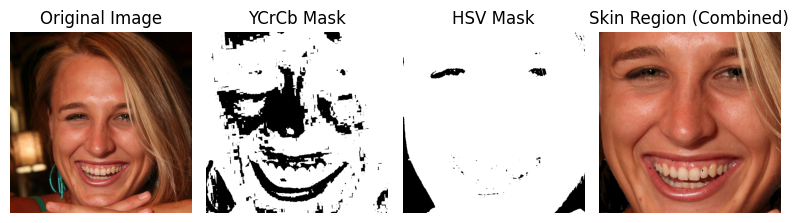

In [10]:
cropped_face, skin = extract_face_and_skin(image)

# 두 마스크(YCrCb, HSV)의 결합
* YCrCb와 HSV 마스크를 결합(cv2.bitwise_or)하여 두 색 공간의 장점을 동시에 활용합니다.
* YCrCb는 피부 영역을 비교적 정확히 감지하고, HSV는 조명 변화와 다양한 피부톤에서 강건성을 제공합니다.
* 두 마스크를 결합하면 피부 영역을 더 넓고 정확하게 감지할 수 있습니다.
    * 하지만, 일부 경우에서 배경이나 다른 물체의 색상이 피부와 비슷하면 오검출 가능성이 있습니다.
    * YCrCb와 HSV 범위를 수동으로 정의했기 때문에, 여전히 모든 이미지에 최적화된 것은 아닙니다.

In [5]:
def extract_face_and_skin(image):
    # dlib 초기화
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('res/shape_predictor_68_face_landmarks.dat')

    # 얼굴 검출
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)
    if len(rects) == 0:
        return None, None, None, None  # 얼굴 미검출 시 None 반환

    rect = rects[0]  # 첫 번째 얼굴만 처리
    shape = predictor(gray, rect)
    shape_np = face_utils.shape_to_np(shape)

    # 얼굴 크롭
    (x, y, w, h) = (rect.left(), rect.top(), rect.width(), rect.height())
    cropped_face = image[max(0, y):y+h, max(0, x):x+w]

    # YCrCb 변환 및 피부 마스크 생성
    ycrcb = cv2.cvtColor(cropped_face, cv2.COLOR_BGR2YCrCb)
    lower_ycrcb = np.array([0, 133, 77], dtype=np.uint8)
    upper_ycrcb = np.array([255, 173, 127], dtype=np.uint8)
    ycrcb_mask = cv2.inRange(ycrcb, lower_ycrcb, upper_ycrcb)

    pre_skin = cv2.bitwise_and(cropped_face, cropped_face, mask=ycrcb_mask)

    # HSV 변환 및 피부 마스크 생성
    hsv = cv2.cvtColor(cropped_face, cv2.COLOR_BGR2HSV)
    lower_hsv = np.array([0, 20, 70], dtype=np.uint8)
    upper_hsv = np.array([25, 255, 255], dtype=np.uint8)
    hsv_mask = cv2.inRange(hsv, lower_hsv, upper_hsv)

    # 두 마스크 결합
    combined_mask = cv2.bitwise_or(ycrcb_mask, hsv_mask)
    skin = cv2.bitwise_and(cropped_face, cropped_face, mask=combined_mask)

    return cropped_face, skin, pre_skin


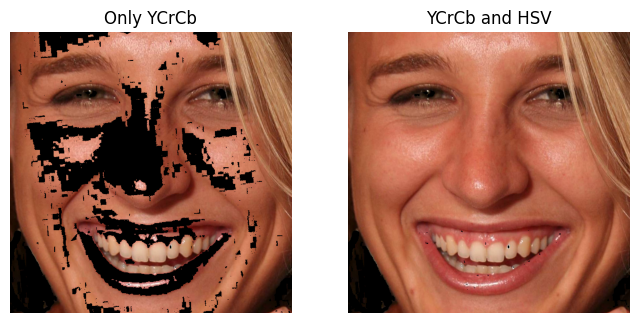

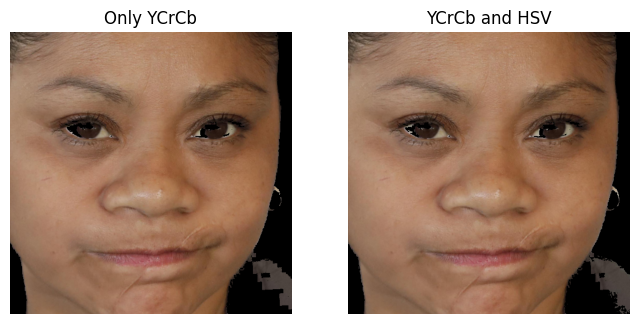

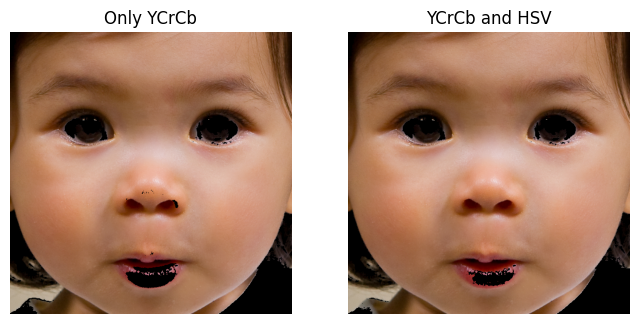

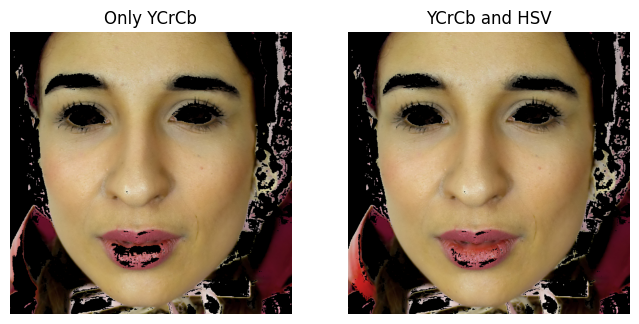

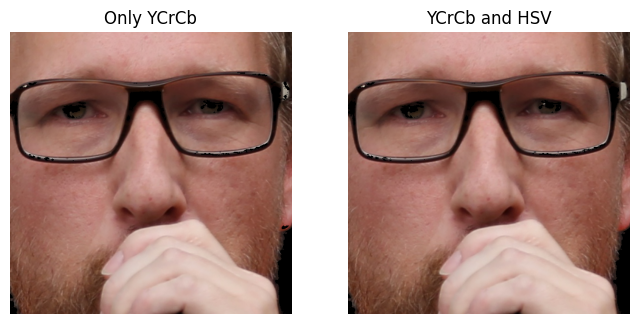

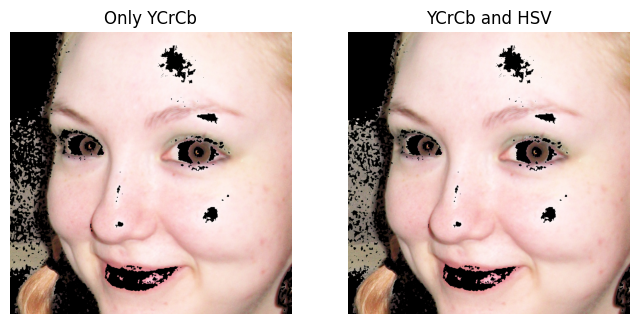

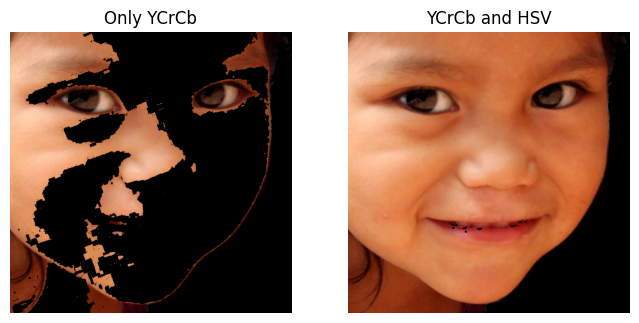

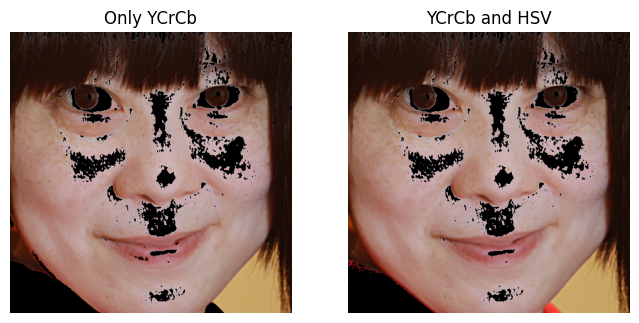

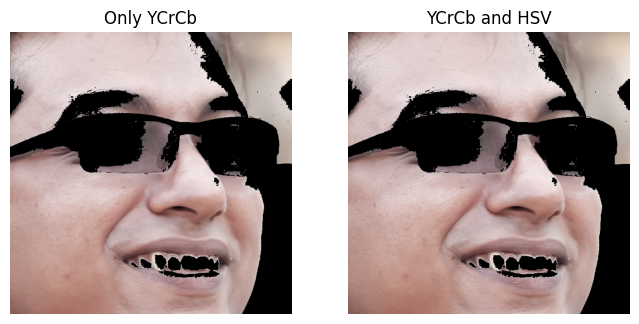

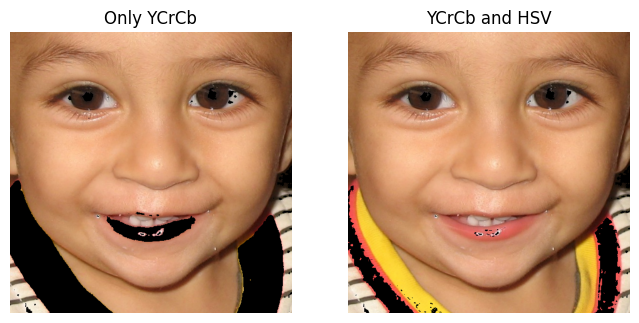

In [12]:
for i in range(10):
    image = cv2.imread(image_paths[i])
    _, skin, pre_skin = extract_face_and_skin(image)
    plt.figure(figsize=(8,6))
    
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(pre_skin, cv2.COLOR_BGR2RGB))
    plt.title("Only YCrCb")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(skin, cv2.COLOR_BGR2RGB))
    plt.title("YCrCb and HSV")
    plt.axis("off")

# 조명값 정규화
조명이 강한 이미지에서는 색상 값이 왜곡될 수 있습니다.
정규화로 조명을 보정하면 결과가 낫지 않을까?

In [6]:
def normalize_lighting(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    l, a, b = cv2.split(lab)

    # CLAHE 적용 (대조 보정)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)

    lab = cv2.merge((l, a, b))
    normalized_image = cv2.cvtColor(lab, cv2.COLOR_Lab2BGR)
    return normalized_image


(-0.5, 555.5, 554.5, -0.5)

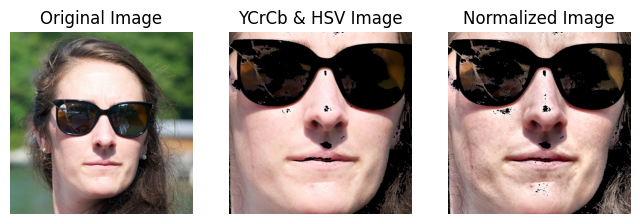

In [19]:
image = cv2.imread("data/57000/57111.png")
_, original_skin, _ = extract_face_and_skin(image)

normalized_image = normalize_lighting(image)
_, normalized_skin, _ = extract_face_and_skin(normalized_image)


plt.figure(figsize=(8,6))

plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")
    
plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(original_skin, cv2.COLOR_BGR2RGB))
plt.title("YCrCb & HSV Image")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(normalized_skin, cv2.COLOR_BGR2RGB))
plt.title("Normalized Image")
plt.axis("off")

결과를 보면 오히려 부자연스럽게 이미지가 변형된 것 같다.
몇몇 이미지에서 피부쪽에도 masking이 됐지만 대부분의 이미지가 잘 나왔으니, 조명에 대한 부분은 신경쓰지 않아도 좋을 것 같다.